#Cài đặt môi trường

In [ ]:
!pip install quickdraw

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow_ranking

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.4/150.4 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 47.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4


#Import thư viện

In [ ]:
import datetime, os
import tensorflow as tf
from tensorflow import keras
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
from quickdraw import QuickDrawDataGroup, QuickDrawData
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers as L
from keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import sparse_categorical_accuracy
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
import glob
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy, categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import tensorflow_ranking as tfr
from keras.applications import imagenet_utils


In [ ]:
def apk(actual, predicted, k=5):
    if len(predicted) > k:
        predicted = predicted[:k]
    score = 0.0
    num_hits = 0.0
    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i + 1.0)
    if not actual:
        return 0.0
    return score / min(len(actual), k)

def mapk(actual, predicted, k=5):
    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])


def top_5_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=5)

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

#Tải dataset

In [ ]:
image_size = (28, 28)
n_classes = 345

In [ ]:
def generate_class_images(name, max_drawings, recognized):
    directory = Path("dataset/" + name)

    if not directory.exists():
        directory.mkdir(parents=True)

    images = QuickDrawDataGroup(name, max_drawings=max_drawings, recognized=recognized)
    for img in images.drawings:
        filename = directory.as_posix() + "/" + str(img.key_id) + ".png"
        img.get_image(stroke_width=3).resize(image_size).save(filename)

for label in QuickDrawData().drawing_names:
    generate_class_images(label, max_drawings=4000, recognized=True)

downloading aircraft carrier from https://storage.googleapis.com/quickdraw_dataset/full/binary/aircraft carrier.bin
download complete
loading aircraft carrier drawings
load complete
downloading airplane from https://storage.googleapis.com/quickdraw_dataset/full/binary/airplane.bin
download complete
loading airplane drawings
load complete
downloading alarm clock from https://storage.googleapis.com/quickdraw_dataset/full/binary/alarm clock.bin
download complete
loading alarm clock drawings
load complete
downloading ambulance from https://storage.googleapis.com/quickdraw_dataset/full/binary/ambulance.bin
download complete
loading ambulance drawings
load complete
downloading angel from https://storage.googleapis.com/quickdraw_dataset/full/binary/angel.bin
download complete
loading angel drawings
load complete
downloading animal migration from https://storage.googleapis.com/quickdraw_dataset/full/binary/animal migration.bin
download complete
loading animal migration drawings
load complete
d

#Chia dataset thành train và test

In [ ]:
batch_size = 256
image_size = (28, 28)

In [ ]:
train_ds = image_dataset_from_directory(
    "/content/dataset/content/dataset",
    #validation_split=0.2,
    #subset="training",
    label_mode='categorical' ,
    #labels = n_classes,
    seed=42,
    color_mode="grayscale",
    image_size=image_size,
    batch_size=batch_size
)

Found 4693190 files belonging to 345 classes.


In [ ]:
train_ds = image_dataset_from_directory(
    "/content/dataset/content/dataset",
    #validation_split=0.2,
    #subset="training",
    label_mode='categorical' ,
    #labels = n_classes,
    seed=42,
    color_mode="grayscale",
    image_size=image_size,
    batch_size=batch_size
)

Found 4830000 files belonging to 345 classes.


In [ ]:

train_ds = image_dataset_from_directory(
    "/content/dataset/content/dataset",
    validation_split=0.2,
    subset="training",
    label_mode='categorical' ,
    #labels = n_classes,
    seed=42,
    color_mode="grayscale",
    image_size=image_size,
    batch_size=batch_size
)

val_ds = image_dataset_from_directory(
    "/content/dataset/content/dataset",
    validation_split=0.2,
    subset="validation",
    label_mode='categorical' ,
    #labels = n_classes,
    seed=42,
    color_mode="grayscale",
    image_size=image_size,
    batch_size=batch_size
)

Found 1380000 files belonging to 345 classes.
Using 1104000 files for training.
Found 1380000 files belonging to 345 classes.
Using 276000 files for validation.


#Hàm code support cho tạo model

In [ ]:
#import tensorflow.compat.v2 as tf


class Lion(tf.keras.optimizers.legacy.Optimizer):
  r"""Optimizer that implements the Lion algorithm."""

  def __init__(self,
               learning_rate=0.0001,
               beta_1=0.9,
               beta_2=0.99,
               wd=0,
               name='lion',
               **kwargs):
    """Construct a new Lion optimizer."""

    super(Lion, self).__init__(name, **kwargs)
    self._set_hyper('learning_rate', kwargs.get('lr', learning_rate))
    self._set_hyper('beta_1', beta_1)
    self._set_hyper('beta_2', beta_2)
    self._set_hyper('wd', wd)

  def _create_slots(self, var_list):
    for var in var_list:
      self.add_slot(var, 'm')

  def _prepare_local(self, var_device, var_dtype, apply_state):
    super(Lion, self)._prepare_local(var_device, var_dtype, apply_state)

    beta_1_t = tf.identity(self._get_hyper('beta_1', var_dtype))
    beta_2_t = tf.identity(self._get_hyper('beta_2', var_dtype))
    wd_t = tf.identity(self._get_hyper('wd', var_dtype))
    lr = apply_state[(var_device, var_dtype)]['lr_t']
    apply_state[(var_device, var_dtype)].update(
        dict(
            lr=lr,
            beta_1_t=beta_1_t,
            one_minus_beta_1_t=1 - beta_1_t,
            beta_2_t=beta_2_t,
            one_minus_beta_2_t=1 - beta_2_t,
            wd_t=wd_t))

  @tf.function(jit_compile=True)
  def _resource_apply_dense(self, grad, var, apply_state=None):
    var_device, var_dtype = var.device, var.dtype.base_dtype
    coefficients = ((apply_state or {}).get((var_device, var_dtype)) or
                    self._fallback_apply_state(var_device, var_dtype))

    m = self.get_slot(var, 'm')
    var_t = var.assign_sub(
        coefficients['lr_t'] *
        (tf.math.sign(m * coefficients['beta_1_t'] +
                      grad * coefficients['one_minus_beta_1_t']) +
         var * coefficients['wd_t']))
    with tf.control_dependencies([var_t]):
      m.assign(m * coefficients['beta_2_t'] +
               grad * coefficients['one_minus_beta_2_t'])

  @tf.function(jit_compile=True)
  def _resource_apply_sparse(self, grad, var, indices, apply_state=None):
    var_device, var_dtype = var.device, var.dtype.base_dtype
    coefficients = ((apply_state or {}).get((var_device, var_dtype)) or
                    self._fallback_apply_state(var_device, var_dtype))

    m = self.get_slot(var, 'm')
    m_t = m.assign(m * coefficients['beta_1_t'])
    m_scaled_g_values = grad * coefficients['one_minus_beta_1_t']
    m_t = m_t.scatter_add(tf.IndexedSlices(m_scaled_g_values, indices))
    var_t = var.assign_sub(coefficients['lr'] *
                           (tf.math.sign(m_t) + var * coefficients['wd_t']))

    with tf.control_dependencies([var_t]):
      m_t = m_t.scatter_add(tf.IndexedSlices(-m_scaled_g_values, indices))
      m_t = m_t.assign(m_t * coefficients['beta_2_t'] /
                       coefficients['beta_1_t'])
      m_scaled_g_values = grad * coefficients['one_minus_beta_2_t']
      m_t.scatter_add(tf.IndexedSlices(m_scaled_g_values, indices))

  def get_config(self):
    config = super(Lion, self).get_config()
    config.update({
        'learning_rate': self._serialize_hyperparameter('learning_rate'),
        'beta_1': self._serialize_hyperparameter('beta_1'),
        'beta_2': self._serialize_hyperparameter('beta_2'),
        'wd': self._serialize_hyperparameter('wd'),
    })
    return config

In [ ]:
def mish(x) -> tf.Tensor:
    x = tf.convert_to_tensor(x)
    return x * tf.math.tanh(tf.math.softplus(x))

#Load lại model để train

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/300/Laipha6.h5',custom_objects={"top_5_accuracy": top_5_accuracy,"Lion":Lion })
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 rescaling_5 (Rescaling)        (None, 28, 28, 1)    0           ['input_6[0][0]']                
                                                                                                  
 batch_normalization_106 (Batch  (None, 28, 28, 1)   4           ['rescaling_5[0][0]']            
 Normalization)                                                                                   
                                                                                                  
 conv2d_70 (Conv2D)             (None, 28, 28, 64)   640         ['batch_normalization_106[0

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=Lion(), metrics=[categorical_crossentropy, categorical_accuracy, top_5_accuracy])
model.summary()

#Đánh giá model

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=Lion(), metrics=[ categorical_accuracy,top_3_accuracy, top_5_accuracy,tfr.keras.metrics.MeanAveragePrecisionMetric(name='MAP@3',topn=3),tfr.keras.metrics.MeanAveragePrecisionMetric(name='MAP@5',topn=5),tfr.keras.metrics.NDCGMetric(name='NDCG@3',topn=3),tfr.keras.metrics.NDCGMetric(name='NDCG@5',topn=5)])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 rescaling_5 (Rescaling)        (None, 28, 28, 1)    0           ['input_6[0][0]']                
                                                                                                  
 batch_normalization_106 (Batch  (None, 28, 28, 1)   4           ['rescaling_5[0][0]']            
 Normalization)                                                                                   
                                                                                                  
 conv2d_70 (Conv2D)             (None, 28, 28, 64)   640         ['batch_normalization_106[0

##Đánh giá trên tập dataset 12K mỗi lớp có recognized là True

In [ ]:
#Model ít parameter(Chế - Không bị over fitting-dùng mish activation +chỉnh sửa thêm (Hàm chính))
model.evaluate(train_ds,batch_size = 256)

18868/18868 [==============================] - 2718s 144ms/step - loss: 0.7186 - categorical_accuracy: 0.8063 - top_3_accuracy: 0.9432 - top_5_accuracy: 0.9670 - MAP@3: 0.8693 - MAP@5: 0.8748 - NDCG@3: 0.8884 - NDCG@5: 0.8982


[0.718621015548706,
 0.8062635660171509,
 0.9431552886962891,
 0.9669809341430664,
 0.8692678213119507,
 0.8747755885124207,
 0.888373076915741,
 0.8982318639755249]

In [ ]:
#Model nhiều parameter (Giống model VGG nhưng điều chỉnh cho phù hợp - Thế nhưng bị overfitting)
model.evaluate(train_ds,batch_size = 256)

18868/18868 [==============================] - 2921s 154ms/step - loss: 0.7223 - categorical_accuracy: 0.7963 - top_3_accuracy: 0.9344 - top_5_accuracy: 0.9596 - MAP@3: 0.8598 - MAP@5: 0.8656 - NDCG@3: 0.8791 - NDCG@5: 0.8895


[0.722277820110321,
 0.7963140606880188,
 0.9343815445899963,
 0.9596157073974609,
 0.8597686290740967,
 0.865604817867279,
 0.8790569305419922,
 0.8895000219345093]

##Đánh giá trên tập dataset 14K mỗi lớp có recognized là None (kết hợp giữa 8000k có recognized là True và 6000k là False) 

In [ ]:
#Model ít parameter(Chế - Không bị over fitting-dùng mish activation +chỉnh sửa thêm (Hàm chính))
model.evaluate(train_ds,batch_size = 256)

18333/18333 [==============================] - 2991s 162ms/step - loss: 2.1712 - categorical_accuracy: 0.5814 - top_3_accuracy: 0.7212 - top_5_accuracy: 0.7622 - MAP@3: 0.6444 - MAP@5: 0.6538 - NDCG@3: 0.6642 - NDCG@5: 0.6811


[2.1712121963500977,
 0.5813632011413574,
 0.721198558807373,
 0.7621574997901917,
 0.6444101333618164,
 0.6538135409355164,
 0.6641949415206909,
 0.6810941696166992]

In [ ]:
#Model nhiều parameter (Giống model VGG nhưng điều chỉnh cho phù hợp - Thế nhưng bị overfitting)
model.evaluate(train_ds,batch_size = 256)

18333/18333 [==============================] - 2817s 153ms/step - loss: 2.5762 - categorical_accuracy: 0.5872 - top_3_accuracy: 0.7131 - top_5_accuracy: 0.7506 - MAP@3: 0.6440 - MAP@5: 0.6526 - NDCG@3: 0.6618 - NDCG@5: 0.6772


[2.5761539936065674,
 0.5871886610984802,
 0.7131047248840332,
 0.750562846660614,
 0.6439567804336548,
 0.652550458908081,
 0.6617738604545593,
 0.6772286295890808]

#Tạo Model

In [ ]:
num_classes = 345
input_shape = (28, 28, 1)

In [ ]:


def inverted_residual_block(inputs, num_filters, strides=1, expansion_ratio=1):
    ## Point-Wise Convolution
    x = L.Conv2D(
        filters=expansion_ratio*inputs.shape[-1],
        kernel_size=1,
        padding="same",
        use_bias=False
    )(inputs)
    x = L.BatchNormalization()(x)
    x = mish(x)

    ## Depth-Wise Convolution
    if strides == 2:
        x = L.ZeroPadding2D(padding=imagenet_utils.correct_pad(x, 3))(x)
    x = L.DepthwiseConv2D(
        3, strides=strides, padding="same" if strides == 1 else "valid", use_bias=False
    )(x)
    x = L.BatchNormalization()(x)
    x = mish(x)

    ## Point-Wise Convolution
    x = L.Conv2D(
        filters=num_filters,
        kernel_size=1,
        padding="same",
        use_bias=False
    )(x)
    x = L.BatchNormalization()(x)

    ## Residual Connection
    if strides == 1 and (inputs.shape == x.shape):
        return L.Add()([inputs, x])
    return x


def ModelStruct(input_shape, num_channels, expansion_ratio, num_classes=1000):
    ## Input layer
    inputs = L.Input(input_shape)
    x = Rescaling(1. / 255)(inputs)
    x = L.BatchNormalization()(x)
    ## Stem
    x = L.Conv2D(
        filters=num_channels[0],
        kernel_size=3,
        strides=1,
        padding="same"
    )(x)
    x = L.BatchNormalization()(x)
    x = mish(x)
    x = inverted_residual_block(x, num_channels[1], strides=1, expansion_ratio=expansion_ratio)
    
    ## Stage 1
    x = inverted_residual_block(x, num_channels[2], strides=2, expansion_ratio=expansion_ratio)
    x = inverted_residual_block(x, num_channels[2], strides=1, expansion_ratio=expansion_ratio)
    x = inverted_residual_block(x, num_channels[2], strides=1, expansion_ratio=expansion_ratio)
    x = L.SpatialDropout2D(0.3)(x)

    ## Stage 2
    x = inverted_residual_block(x, num_channels[3], strides=2, expansion_ratio=expansion_ratio)
    x = inverted_residual_block(x, num_channels[3], strides=1, expansion_ratio=expansion_ratio)
    x = inverted_residual_block(x, num_channels[3], strides=1, expansion_ratio=expansion_ratio)
    x = L.SpatialDropout2D(0.3)(x)

    ## Stage 3
    x = inverted_residual_block(x, num_channels[4], strides=2, expansion_ratio=expansion_ratio)
    x = inverted_residual_block(x, num_channels[4], strides=1, expansion_ratio=expansion_ratio)
    x = inverted_residual_block(x, num_channels[4], strides=1, expansion_ratio=expansion_ratio)
    x = L.SpatialDropout2D(0.3)(x)

    ## Stage 4
    x = L.Conv2D(
        filters=num_channels[5],
        kernel_size=1,
        padding="same"
    )(x)
    x = L.BatchNormalization()(x)
    x = mish(x)
    x = inverted_residual_block(x, num_channels[5], strides=1, expansion_ratio=expansion_ratio)

    ## Classifier
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = L.Dropout(0.5)(x)
    outputs = L.Dense(num_classes, activation="softmax")(x)
    model = tf.keras.models.Model(inputs, outputs)
    return model


def Create_model(input_shape, num_classes):
    num_channels = [64,64,96,128,256,384]
    expansion_ratio = 4

    return ModelStruct(
        input_shape,
        num_channels,
        expansion_ratio,
        num_classes=num_classes
    )



In [ ]:
model = Create_model(input_shape, num_classes)
lion = Lion(learning_rate = 1e-4,wd=1e-2)
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.15), optimizer=lion, metrics=[categorical_crossentropy, categorical_accuracy, top_5_accuracy,tfr.keras.metrics.MeanAveragePrecisionMetric(name='MAP@5',topn=5),tfr.keras.metrics.NDCGMetric(name='NDCG@5',topn=5)])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 rescaling (Rescaling)          (None, 28, 28, 1)    0           ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 28, 28, 1)   4           ['rescaling[0][0]']              
 alization)                                                                                       
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 64)   640         ['batch_normalization[0][0]']

#Xem cách thức của model

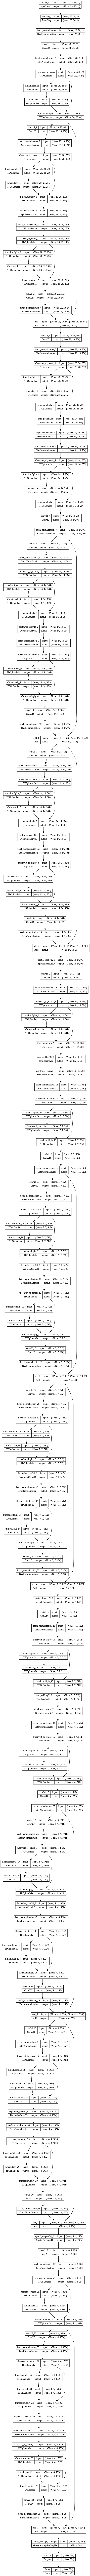

In [ ]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
)

#Visualize quá trình train

In [ ]:
loss = [4.19620943069458, 2.861928701400757, 2.524639844894409, 2.357067346572876, 2.2499005794525146, 2.174353837966919,2.2267162799835205, 2.133114814758301, 2.058868408203125,2.005315065383911, 1.9564404487609863, 1.921690583229065,1.934657096862793, 1.8810484409332275, 1.8441135883331299,1.816260814666748, 1.7924150228500366, 1.772385835647583,1.7538034915924072, 1.7393344640731812,1.7258237600326538, 1.7133615016937256,1.7018765211105347, 1.6924333572387695,]
categorical_crossentropy =[3.827249765396118, 2.2134571075439453, 1.815254807472229, 1.6211519241333008, 1.4982805252075195, 1.4116467237472534,1.47517991065979, 1.3724381923675537, 1.2902432680130005,1.2307415008544922, 1.17551851272583, 1.1362266540527344,1.1648589372634888, 1.1056809425354004, 1.0650655031204224,1.0345990657806396, 1.0083236694335938, 0.9863483905792236,0.9661715626716614, 0.9500073790550232,0.9352794289588928, 0.9213845133781433,0.9090057015419006, 0.8984994888305664,]
acc = [0.20451690256595612, 0.4719353914260864, 0.5594263076782227, 0.6033605337142944, 0.6330797076225281, 0.6528170108795166,0.6372826099395752, 0.6626902222633362, 0.6816787719726562,0.6966213583946228, 0.7106008529663086, 0.7194414138793945,0.7134519815444946, 0.7276820540428162, 0.73745197057724,0.7453804612159729, 0.7522073984146118, 0.7574855089187622,0.7623641490936279, 0.7665770053863525,0.7703396677970886, 0.7738369703292847,0.7771304249763489, 0.7797228097915649,]
top5_acc =[0.43061593174934387, 0.7707366943359375, 0.8378291130065918, 0.8674969673156738, 0.8852143883705139, 0.8972705602645874,0.8890549540519714, 0.903285026550293, 0.9140881896018982,0.9217904806137085, 0.9283756017684937, 0.9337530136108398,0.928473711013794, 0.9352046847343445, 0.9398831725120544,0.9432717561721802, 0.9461367726325989, 0.9486277103424072,0.9504936337471008, 0.952266275882721,0.9535353183746338, 0.9552209973335266,0.9560724496841431, 0.9573134183883667,]
MAP_5 =[0.2868010699748993, 0.5874004364013672, 0.6692796349525452, 0.7088857293128967, 0.7344481348991394, 0.7517463564872742,0.7387001514434814, 0.7601184844970703, 0.7767742872238159,0.7890623211860657, 0.8002482652664185, 0.8080363869667053,0.8021975755691528, 0.8137890100479126, 0.821739673614502,0.8280099630355835, 0.8332467675209045, 0.8375541567802429,0.8413071632385254, 0.8446584343910217,0.8475329279899597, 0.8503763675689697,0.8527359962463379, 0.854845404624939,]
NDCG_5=[0.322547048330307, 0.6333441138267517, 0.7116394639015198, 0.7488183379173279, 0.7724460959434509, 0.7884585857391357,0.7766029238700867, 0.79623943567276, 0.8114728927612305,0.8226198554039001, 0.8326551914215088, 0.8398521542549133,0.8341487050056458, 0.8445370197296143, 0.8516752123832703,0.8572281002998352, 0.8618661165237427, 0.8657264709472656,0.8690069913864136, 0.8719669580459595,0.8744403719902039, 0.8769966959953308,0.8789823651313782, 0.8808743953704834,]
val_loss =[2.918238878250122, 2.403615951538086, 2.236853837966919, 2.161958694458008, 2.1011240482330322, 2.047941207885742,2.0908164978027344, 2.0269694328308105, 1.9823403358459473,1.9587494134902954, 1.9354517459869385, 1.9162991046905518,1.7893116474151611, 1.7653818130493164, 1.751439094543457,1.7474089860916138, 1.741615891456604, 1.7277003526687622,1.7190172672271729, 1.7209527492523193,1.7110995054244995, 1.7114620208740234,1.7082922458648682, 1.7060719728469849,]
val_categorical_crossentropy =[2.2340946197509766, 1.6122020483016968, 1.4132050275802612, 1.3351315259933472, 1.2639557123184204, 1.2004785537719727,1.249951958656311, 1.1790528297424316, 1.127690076828003,1.1099456548690796, 1.071753978729248, 1.0560245513916016,0.9243955612182617, 0.8931751847267151, 0.8748816847801208,0.8677740097045898, 0.8642532229423523, 0.8383443355560303,0.826572597026825, 0.8218509554862976,0.8272040486335754, 0.8147132992744446,0.8136197924613953, 0.8086104989051819,]
val_acc =[0.4536352753639221, 0.5866183638572693, 0.6324396133422852, 0.6488526463508606, 0.6658212542533875, 0.6805434823036194,0.6694082021713257, 0.6875362396240234, 0.7002173662185669,0.7050966024398804, 0.7126328349113464, 0.7171135544776917,0.7510470747947693, 0.7582427263259888, 0.7616884112358093,0.7629782557487488, 0.7643116116523743, 0.7697029113769531,0.7727282643318176, 0.7732210159301758,0.7731050848960876, 0.7752137780189514,0.7753985524177551, 0.7776666879653931,]
top5_val_acc =[0.7552294731140137, 0.8581883907318115, 0.8865458965301514, 0.8977053165435791, 0.9064854979515076, 0.9150000214576721,0.9085386395454407, 0.918055534362793, 0.9239975810050964,0.9262802004814148, 0.9298067688941956, 0.9322101473808289,0.9468913078308105, 0.9495724439620972, 0.9514456391334534,0.9516268372535706, 0.9523659348487854, 0.9542354941368103,0.9552645087242126, 0.9553876519203186,0.9557536244392395, 0.9564710259437561,0.9567645192146301, 0.957043468952179,]
val_MAP_5 =[0.569425106048584, 0.6945867538452148, 0.7343182563781738, 0.7494929432868958, 0.7637602090835571, 0.7761616110801697,0.7667795419692993, 0.7816388607025146, 0.7919486165046692,0.7958257794380188, 0.8022090196609497, 0.8058795928955078,0.8329310417175293, 0.8383216261863708, 0.8413640260696411,0.8422980904579163, 0.8433071970939636, 0.8473773002624512,0.8496262431144714, 0.8499609231948853,0.8500447869300842, 0.8516727685928345,0.851891815662384, 0.8533108830451965,]
val_NDCG_5=[0.6159355044364929, 0.7357537746429443, 0.7726651430130005, 0.7868775129318237, 0.799795925617218, 0.8112310171127319,0.8025770783424377, 0.8160977363586426, 0.8253241181373596,0.8288044333457947, 0.834494948387146, 0.8378486633300781,0.861825704574585, 0.8665338158607483, 0.8692951798439026,0.8700425624847412, 0.870979905128479, 0.8745010495185852,0.8764415383338928, 0.8767213821411133,0.8768801093101501, 0.8782819509506226,0.878517746925354, 0.8796476125717163,]

In [ ]:
indx = [i for i in range(1,len(loss))]

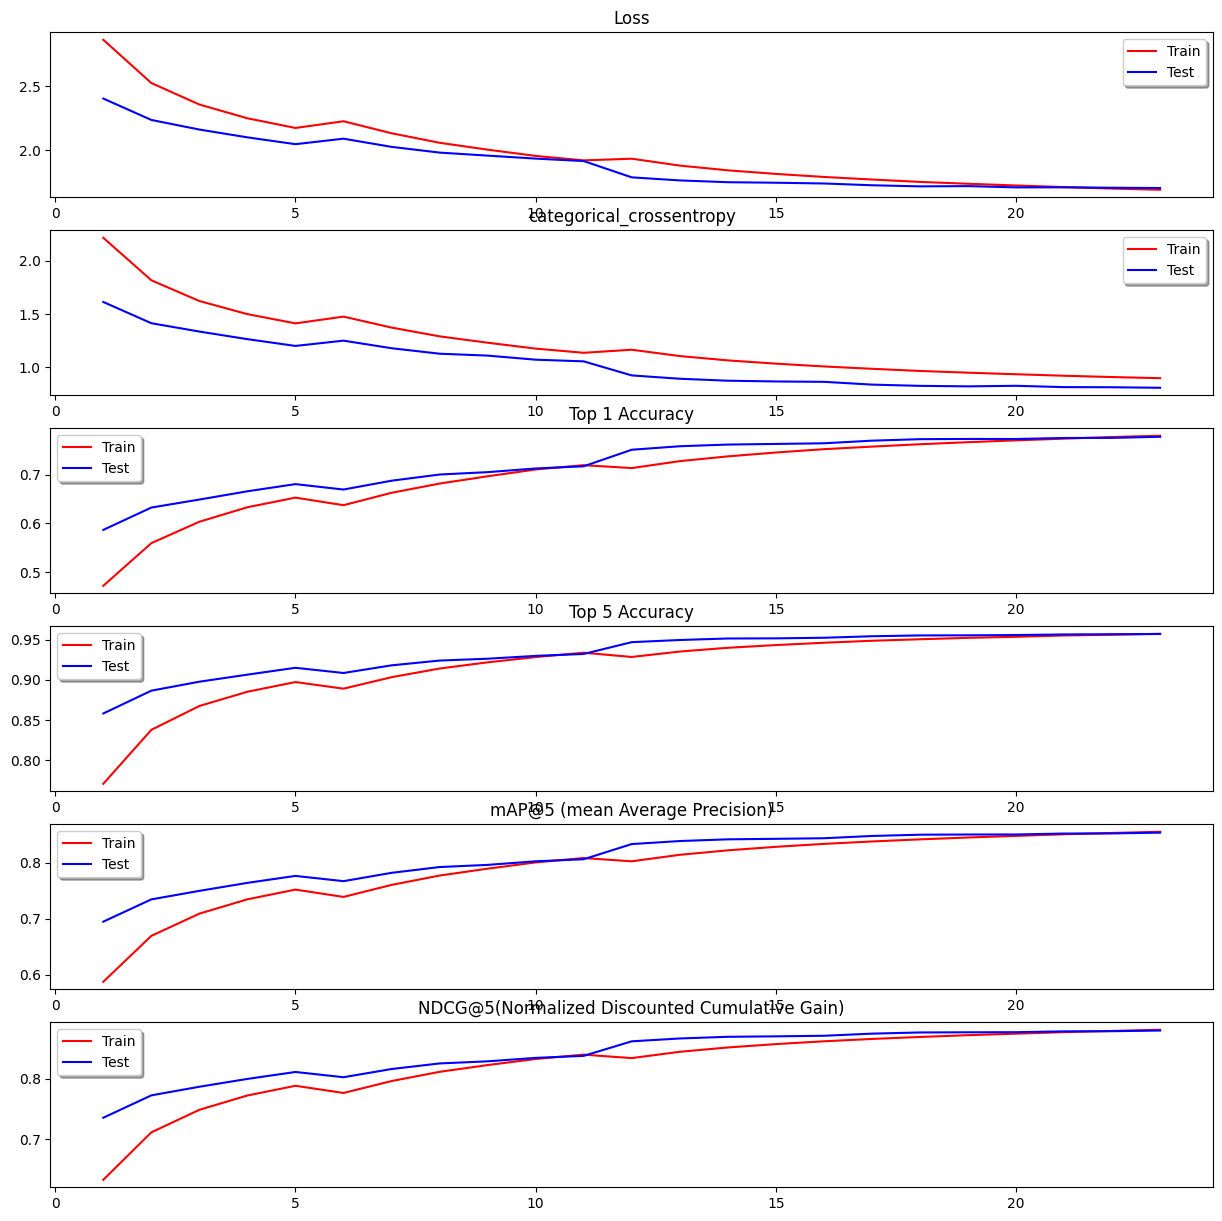

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(6,1,figsize=(15,15))

ax[0].plot(indx,loss[1:], color='r', label="Train")
ax[0].plot(indx,val_loss[1:], color='b', label="Test")
ax[0].set_title("Loss")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(indx,categorical_crossentropy[1:], color='r', label="Train")
ax[1].plot(indx,val_categorical_crossentropy[1:], color='b', label="Test")
ax[1].set_title("categorical_crossentropy")
legend = ax[1].legend(loc='best', shadow=True)

ax[2].plot(indx,acc[1:], color='r', label="Train")
ax[2].plot(indx,val_acc[1:], color='b', label="Test")
ax[2].set_title("Top 1 Accuracy")
legend = ax[2].legend(loc='best', shadow=True)

ax[3].plot(indx,top5_acc[1:], color='r', label="Train")
ax[3].plot(indx,top5_val_acc[1:], color='b', label="Test")
ax[3].set_title('Top 5 Accuracy')
legend = ax[3].legend(loc='best', shadow=True)

ax[4].plot(indx,MAP_5[1:], color='r', label="Train")
ax[4].plot(indx,val_MAP_5[1:], color='b', label="Test")
ax[4].set_title('mAP@5 (mean Average Precision)')
legend = ax[4].legend(loc='best', shadow=True)

ax[5].plot(indx,NDCG_5[1:], color='r', label="Train")
ax[5].plot(indx,val_NDCG_5[1:], color='b', label="Test")
ax[5].set_title('NDCG@5(Normalized Discounted Cumulative Gain)')
legend = ax[5].legend(loc='best', shadow=True)


#CallBack và quá trình train

In [ ]:
weight_path="/content/drive/MyDrive/{}_weights.best.hdf5".format('quick_draw_model')
callbacks = [
    ReduceLROnPlateau(monitor='val_MAP@5', factor=0.75, patience=2, min_delta=0.001,
                          mode='max', min_lr=1e-6, verbose=1),
    ModelCheckpoint(weight_path, monitor='val_MAP@5', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only = False),
    EarlyStopping(monitor='val_MAP@5',patience=6,verbose=1,mode='max')
]

In [ ]:
history=model.fit(train_ds, validation_data=val_ds, verbose=1, epochs=6,callbacks = callbacks)

Epoch 1/6
1294/1294 [==============================] - ETA: 0s - loss: 4.1962 - categorical_crossentropy: 3.8272 - categorical_accuracy: 0.2045 - top_5_accuracy: 0.4306 - MAP@5: 0.2868 - NDCG@5: 0.3225
Epoch 1: val_MAP@5 improved from -inf to 0.56943, saving model to /content/drive/MyDrive/quick_draw_model_weights.best.hdf5
1294/1294 [==============================] - 562s 427ms/step - loss: 4.1962 - categorical_crossentropy: 3.8272 - categorical_accuracy: 0.2045 - top_5_accuracy: 0.4306 - MAP@5: 0.2868 - NDCG@5: 0.3225 - val_loss: 2.9182 - val_categorical_crossentropy: 2.2341 - val_categorical_accuracy: 0.4536 - val_top_5_accuracy: 0.7552 - val_MAP@5: 0.5694 - val_NDCG@5: 0.6159 - lr: 0.0100
Epoch 2/6
1294/1294 [==============================] - ETA: 0s - loss: 2.8619 - categorical_crossentropy: 2.2135 - categorical_accuracy: 0.4719 - top_5_accuracy: 0.7707 - MAP@5: 0.5874 - NDCG@5: 0.6333
Epoch 2: val_MAP@5 improved from 0.56943 to 0.69459, saving model to /content/drive/MyDrive/quic

In [ ]:
for i in history.history:
  print(i,history.history[i])

loss [4.19620943069458, 2.861928701400757, 2.524639844894409, 2.357067346572876, 2.2499005794525146, 2.174353837966919]
categorical_crossentropy [3.827249765396118, 2.2134571075439453, 1.815254807472229, 1.6211519241333008, 1.4982805252075195, 1.4116467237472534]
categorical_accuracy [0.20451690256595612, 0.4719353914260864, 0.5594263076782227, 0.6033605337142944, 0.6330797076225281, 0.6528170108795166]
top_5_accuracy [0.43061593174934387, 0.7707366943359375, 0.8378291130065918, 0.8674969673156738, 0.8852143883705139, 0.8972705602645874]
MAP@5 [0.2868010699748993, 0.5874004364013672, 0.6692796349525452, 0.7088857293128967, 0.7344481348991394, 0.7517463564872742]
NDCG@5 [0.322547048330307, 0.6333441138267517, 0.7116394639015198, 0.7488183379173279, 0.7724460959434509, 0.7884585857391357]
val_loss [2.918238878250122, 2.403615951538086, 2.236853837966919, 2.161958694458008, 2.1011240482330322, 2.047941207885742]
val_categorical_crossentropy [2.2340946197509766, 1.6122020483016968, 1.41320

In [ ]:
history1=model.fit(train_ds, validation_data=val_ds, verbose=1, epochs=3,callbacks = callbacks)

Epoch 1/3
1294/1294 [==============================] - ETA: 0s - loss: 2.2267 - categorical_crossentropy: 1.4752 - categorical_accuracy: 0.6373 - top_5_accuracy: 0.8891 - MAP@5: 0.7387 - NDCG@5: 0.7766
Epoch 1: val_MAP@5 did not improve from 0.77616
1294/1294 [==============================] - 560s 426ms/step - loss: 2.2267 - categorical_crossentropy: 1.4752 - categorical_accuracy: 0.6373 - top_5_accuracy: 0.8891 - MAP@5: 0.7387 - NDCG@5: 0.7766 - val_loss: 2.0908 - val_categorical_crossentropy: 1.2500 - val_categorical_accuracy: 0.6694 - val_top_5_accuracy: 0.9085 - val_MAP@5: 0.7668 - val_NDCG@5: 0.8026 - lr: 1.0000e-04
Epoch 2/3
1294/1294 [==============================] - ETA: 0s - loss: 2.1331 - categorical_crossentropy: 1.3724 - categorical_accuracy: 0.6627 - top_5_accuracy: 0.9033 - MAP@5: 0.7601 - NDCG@5: 0.7962
Epoch 2: val_MAP@5 improved from 0.77616 to 0.78164, saving model to /content/drive/MyDrive/quick_draw_model_weights.best.hdf5
1294/1294 [==============================

In [ ]:
for i in history1.history:
  print(i,history1.history[i])

loss [2.2267162799835205, 2.133114814758301, 2.058868408203125]
categorical_crossentropy [1.47517991065979, 1.3724381923675537, 1.2902432680130005]
categorical_accuracy [0.6372826099395752, 0.6626902222633362, 0.6816787719726562]
top_5_accuracy [0.8890549540519714, 0.903285026550293, 0.9140881896018982]
MAP@5 [0.7387001514434814, 0.7601184844970703, 0.7767742872238159]
NDCG@5 [0.7766029238700867, 0.79623943567276, 0.8114728927612305]
val_loss [2.0908164978027344, 2.0269694328308105, 1.9823403358459473]
val_categorical_crossentropy [1.249951958656311, 1.1790528297424316, 1.127690076828003]
val_categorical_accuracy [0.6694082021713257, 0.6875362396240234, 0.7002173662185669]
val_top_5_accuracy [0.9085386395454407, 0.918055534362793, 0.9239975810050964]
val_MAP@5 [0.7667795419692993, 0.7816388607025146, 0.7919486165046692]
val_NDCG@5 [0.8025770783424377, 0.8160977363586426, 0.8253241181373596]
lr [1e-04, 1e-04, 1e-04]


In [ ]:
history=model.fit(train_ds, validation_data=val_ds, verbose=1, epochs=3,callbacks = callbacks)

Epoch 1/3
1294/1294 [==============================] - ETA: 0s - loss: 2.0053 - categorical_crossentropy: 1.2307 - categorical_accuracy: 0.6966 - top_5_accuracy: 0.9218 - MAP@5: 0.7891 - NDCG@5: 0.8226
Epoch 1: val_MAP@5 improved from 0.79195 to 0.79583, saving model to /content/drive/MyDrive/quick_draw_model_weights.best.hdf5
1294/1294 [==============================] - 550s 425ms/step - loss: 2.0053 - categorical_crossentropy: 1.2307 - categorical_accuracy: 0.6966 - top_5_accuracy: 0.9218 - MAP@5: 0.7891 - NDCG@5: 0.8226 - val_loss: 1.9587 - val_categorical_crossentropy: 1.1099 - val_categorical_accuracy: 0.7051 - val_top_5_accuracy: 0.9263 - val_MAP@5: 0.7958 - val_NDCG@5: 0.8288 - lr: 1.0000e-04
Epoch 2/3
1294/1294 [==============================] - ETA: 0s - loss: 1.9564 - categorical_crossentropy: 1.1755 - categorical_accuracy: 0.7106 - top_5_accuracy: 0.9284 - MAP@5: 0.8002 - NDCG@5: 0.8327
Epoch 2: val_MAP@5 improved from 0.79583 to 0.80221, saving model to /content/drive/MyDri

In [ ]:
for i in history.history:
  print(i,history.history[i])

loss [2.005315065383911, 1.9564404487609863, 1.921690583229065]
categorical_crossentropy [1.2307415008544922, 1.17551851272583, 1.1362266540527344]
categorical_accuracy [0.6966213583946228, 0.7106008529663086, 0.7194414138793945]
top_5_accuracy [0.9217904806137085, 0.9283756017684937, 0.9337530136108398]
MAP@5 [0.7890623211860657, 0.8002482652664185, 0.8080363869667053]
NDCG@5 [0.8226198554039001, 0.8326551914215088, 0.8398521542549133]
val_loss [1.9587494134902954, 1.9354517459869385, 1.9162991046905518]
val_categorical_crossentropy [1.1099456548690796, 1.071753978729248, 1.0560245513916016]
val_categorical_accuracy [0.7050966024398804, 0.7126328349113464, 0.7171135544776917]
val_top_5_accuracy [0.9262802004814148, 0.9298067688941956, 0.9322101473808289]
val_MAP@5 [0.7958257794380188, 0.8022090196609497, 0.8058795928955078]
val_NDCG@5 [0.8288044333457947, 0.834494948387146, 0.8378486633300781]
lr [1e-04, 1e-04, 1e-04]


In [ ]:
history=model.fit(train_ds, validation_data=val_ds, verbose=1, epochs=3,callbacks = callbacks)

Epoch 1/3
4313/4313 [==============================] - ETA: 0s - loss: 1.9347 - categorical_crossentropy: 1.1649 - categorical_accuracy: 0.7135 - top_5_accuracy: 0.9285 - MAP@5: 0.8022 - NDCG@5: 0.8341
Epoch 1: val_MAP@5 improved from -inf to 0.83293, saving model to /content/drive/MyDrive/quick_draw_model_weights.best.hdf5
4313/4313 [==============================] - 1881s 431ms/step - loss: 1.9347 - categorical_crossentropy: 1.1649 - categorical_accuracy: 0.7135 - top_5_accuracy: 0.9285 - MAP@5: 0.8022 - NDCG@5: 0.8341 - val_loss: 1.7893 - val_categorical_crossentropy: 0.9244 - val_categorical_accuracy: 0.7510 - val_top_5_accuracy: 0.9469 - val_MAP@5: 0.8329 - val_NDCG@5: 0.8618 - lr: 1.0000e-04
Epoch 2/3
4313/4313 [==============================] - ETA: 0s - loss: 1.8810 - categorical_crossentropy: 1.1057 - categorical_accuracy: 0.7277 - top_5_accuracy: 0.9352 - MAP@5: 0.8138 - NDCG@5: 0.8445
Epoch 2: val_MAP@5 improved from 0.83293 to 0.83832, saving model to /content/drive/MyDrive

In [ ]:
for i in history.history:
  print(i,history.history[i])

loss [1.934657096862793, 1.8810484409332275, 1.8441135883331299]
categorical_crossentropy [1.1648589372634888, 1.1056809425354004, 1.0650655031204224]
categorical_accuracy [0.7134519815444946, 0.7276820540428162, 0.73745197057724]
top_5_accuracy [0.928473711013794, 0.9352046847343445, 0.9398831725120544]
MAP@5 [0.8021975755691528, 0.8137890100479126, 0.821739673614502]
NDCG@5 [0.8341487050056458, 0.8445370197296143, 0.8516752123832703]
val_loss [1.7893116474151611, 1.7653818130493164, 1.751439094543457]
val_categorical_crossentropy [0.9243955612182617, 0.8931751847267151, 0.8748816847801208]
val_categorical_accuracy [0.7510470747947693, 0.7582427263259888, 0.7616884112358093]
val_top_5_accuracy [0.9468913078308105, 0.9495724439620972, 0.9514456391334534]
val_MAP@5 [0.8329310417175293, 0.8383216261863708, 0.8413640260696411]
val_NDCG@5 [0.861825704574585, 0.8665338158607483, 0.8692951798439026]
lr [1e-04, 1e-04, 1e-04]


In [ ]:
history=model.fit(train_ds, validation_data=val_ds, verbose=1, epochs=3,callbacks = callbacks)

Epoch 1/3
4313/4313 [==============================] - ETA: 0s - loss: 1.8163 - categorical_crossentropy: 1.0346 - categorical_accuracy: 0.7454 - top_5_accuracy: 0.9433 - MAP@5: 0.8280 - NDCG@5: 0.8572
Epoch 1: val_MAP@5 improved from 0.84136 to 0.84230, saving model to /content/drive/MyDrive/quick_draw_model_weights.best.hdf5
4313/4313 [==============================] - 1830s 424ms/step - loss: 1.8163 - categorical_crossentropy: 1.0346 - categorical_accuracy: 0.7454 - top_5_accuracy: 0.9433 - MAP@5: 0.8280 - NDCG@5: 0.8572 - val_loss: 1.7474 - val_categorical_crossentropy: 0.8678 - val_categorical_accuracy: 0.7630 - val_top_5_accuracy: 0.9516 - val_MAP@5: 0.8423 - val_NDCG@5: 0.8700 - lr: 1.0000e-04
Epoch 2/3
4313/4313 [==============================] - ETA: 0s - loss: 1.7924 - categorical_crossentropy: 1.0083 - categorical_accuracy: 0.7522 - top_5_accuracy: 0.9461 - MAP@5: 0.8332 - NDCG@5: 0.8619
Epoch 2: val_MAP@5 improved from 0.84230 to 0.84331, saving model to /content/drive/MyDr

In [ ]:
for i in history.history:
  print(i,history.history[i])

loss [1.816260814666748, 1.7924150228500366, 1.772385835647583]
categorical_crossentropy [1.0345990657806396, 1.0083236694335938, 0.9863483905792236]
categorical_accuracy [0.7453804612159729, 0.7522073984146118, 0.7574855089187622]
top_5_accuracy [0.9432717561721802, 0.9461367726325989, 0.9486277103424072]
MAP@5 [0.8280099630355835, 0.8332467675209045, 0.8375541567802429]
NDCG@5 [0.8572281002998352, 0.8618661165237427, 0.8657264709472656]
val_loss [1.7474089860916138, 1.741615891456604, 1.7277003526687622]
val_categorical_crossentropy [0.8677740097045898, 0.8642532229423523, 0.8383443355560303]
val_categorical_accuracy [0.7629782557487488, 0.7643116116523743, 0.7697029113769531]
val_top_5_accuracy [0.9516268372535706, 0.9523659348487854, 0.9542354941368103]
val_MAP@5 [0.8422980904579163, 0.8433071970939636, 0.8473773002624512]
val_NDCG@5 [0.8700425624847412, 0.870979905128479, 0.8745010495185852]
lr [1e-04, 1e-04, 1e-04]


In [ ]:
history=model.fit(train_ds, validation_data=val_ds, verbose=1, epochs=2,callbacks = callbacks)

Epoch 1/2
4313/4313 [==============================] - ETA: 0s - loss: 1.7538 - categorical_crossentropy: 0.9662 - categorical_accuracy: 0.7624 - top_5_accuracy: 0.9505 - MAP@5: 0.8413 - NDCG@5: 0.8690
Epoch 1: val_MAP@5 improved from -inf to 0.84963, saving model to /content/drive/MyDrive/300/quick_draw_model_weights.best.hdf5
4313/4313 [==============================] - 1907s 436ms/step - loss: 1.7538 - categorical_crossentropy: 0.9662 - categorical_accuracy: 0.7624 - top_5_accuracy: 0.9505 - MAP@5: 0.8413 - NDCG@5: 0.8690 - val_loss: 1.7190 - val_categorical_crossentropy: 0.8266 - val_categorical_accuracy: 0.7727 - val_top_5_accuracy: 0.9553 - val_MAP@5: 0.8496 - val_NDCG@5: 0.8764 - lr: 1.0000e-04
Epoch 2/2
4313/4313 [==============================] - ETA: 0s - loss: 1.7393 - categorical_crossentropy: 0.9500 - categorical_accuracy: 0.7666 - top_5_accuracy: 0.9523 - MAP@5: 0.8447 - NDCG@5: 0.8720
Epoch 2: val_MAP@5 improved from 0.84963 to 0.84996, saving model to /content/drive/MyD

In [ ]:
for i in history.history:
  print(i,history.history[i])

loss [1.7538034915924072, 1.7393344640731812]
categorical_crossentropy [0.9661715626716614, 0.9500073790550232]
categorical_accuracy [0.7623641490936279, 0.7665770053863525]
top_5_accuracy [0.9504936337471008, 0.952266275882721]
MAP@5 [0.8413071632385254, 0.8446584343910217]
NDCG@5 [0.8690069913864136, 0.8719669580459595]
val_loss [1.7190172672271729, 1.7209527492523193]
val_categorical_crossentropy [0.826572597026825, 0.8218509554862976]
val_categorical_accuracy [0.7727282643318176, 0.7732210159301758]
val_top_5_accuracy [0.9552645087242126, 0.9553876519203186]
val_MAP@5 [0.8496262431144714, 0.8499609231948853]
val_NDCG@5 [0.8764415383338928, 0.8767213821411133]
lr [1e-04, 1e-04]


In [ ]:
history=model.fit(train_ds, validation_data=val_ds, verbose=1, epochs=2,callbacks = callbacks)

Epoch 1/2
4313/4313 [==============================] - ETA: 0s - loss: 1.7258 - categorical_crossentropy: 0.9353 - categorical_accuracy: 0.7703 - top_5_accuracy: 0.9535 - MAP@5: 0.8475 - NDCG@5: 0.8744
Epoch 1: val_MAP@5 improved from 0.84996 to 0.85004, saving model to /content/drive/MyDrive/300/quick_draw_model_weights.best.hdf5
4313/4313 [==============================] - 1883s 436ms/step - loss: 1.7258 - categorical_crossentropy: 0.9353 - categorical_accuracy: 0.7703 - top_5_accuracy: 0.9535 - MAP@5: 0.8475 - NDCG@5: 0.8744 - val_loss: 1.7111 - val_categorical_crossentropy: 0.8272 - val_categorical_accuracy: 0.7731 - val_top_5_accuracy: 0.9558 - val_MAP@5: 0.8500 - val_NDCG@5: 0.8769 - lr: 1.0000e-04
Epoch 2/2
4313/4313 [==============================] - ETA: 0s - loss: 1.7134 - categorical_crossentropy: 0.9214 - categorical_accuracy: 0.7738 - top_5_accuracy: 0.9552 - MAP@5: 0.8504 - NDCG@5: 0.8770
Epoch 2: val_MAP@5 improved from 0.85004 to 0.85167, saving model to /content/drive/

In [ ]:
for i in history.history:
  print(i,history.history[i])

loss [1.7258237600326538, 1.7133615016937256]
categorical_crossentropy [0.9352794289588928, 0.9213845133781433]
categorical_accuracy [0.7703396677970886, 0.7738369703292847]
top_5_accuracy [0.9535353183746338, 0.9552209973335266]
MAP@5 [0.8475329279899597, 0.8503763675689697]
NDCG@5 [0.8744403719902039, 0.8769966959953308]
val_loss [1.7110995054244995, 1.7114620208740234]
val_categorical_crossentropy [0.8272040486335754, 0.8147132992744446]
val_categorical_accuracy [0.7731050848960876, 0.7752137780189514]
val_top_5_accuracy [0.9557536244392395, 0.9564710259437561]
val_MAP@5 [0.8500447869300842, 0.8516727685928345]
val_NDCG@5 [0.8768801093101501, 0.8782819509506226]
lr [1e-04, 1e-04]


In [ ]:
history=model.fit(train_ds, validation_data=val_ds, verbose=1, epochs=2,callbacks = callbacks)

Epoch 1/2
4313/4313 [==============================] - ETA: 0s - loss: 1.7019 - categorical_crossentropy: 0.9090 - categorical_accuracy: 0.7771 - top_5_accuracy: 0.9561 - MAP@5: 0.8527 - NDCG@5: 0.8790
Epoch 1: val_MAP@5 improved from 0.85167 to 0.85189, saving model to /content/drive/MyDrive/300/quick_draw_model_weights.best.hdf5
4313/4313 [==============================] - 1881s 436ms/step - loss: 1.7019 - categorical_crossentropy: 0.9090 - categorical_accuracy: 0.7771 - top_5_accuracy: 0.9561 - MAP@5: 0.8527 - NDCG@5: 0.8790 - val_loss: 1.7083 - val_categorical_crossentropy: 0.8136 - val_categorical_accuracy: 0.7754 - val_top_5_accuracy: 0.9568 - val_MAP@5: 0.8519 - val_NDCG@5: 0.8785 - lr: 1.0000e-04
Epoch 2/2
4313/4313 [==============================] - ETA: 0s - loss: 1.6924 - categorical_crossentropy: 0.8985 - categorical_accuracy: 0.7797 - top_5_accuracy: 0.9573 - MAP@5: 0.8548 - NDCG@5: 0.8809
Epoch 2: val_MAP@5 improved from 0.85189 to 0.85331, saving model to /content/drive/

In [ ]:
for i in history.history:
  print(i,history.history[i])

loss [1.7018765211105347, 1.6924333572387695]
categorical_crossentropy [0.9090057015419006, 0.8984994888305664]
categorical_accuracy [0.7771304249763489, 0.7797228097915649]
top_5_accuracy [0.9560724496841431, 0.9573134183883667]
MAP@5 [0.8527359962463379, 0.854845404624939]
NDCG@5 [0.8789823651313782, 0.8808743953704834]
val_loss [1.7082922458648682, 1.7060719728469849]
val_categorical_crossentropy [0.8136197924613953, 0.8086104989051819]
val_categorical_accuracy [0.7753985524177551, 0.7776666879653931]
val_top_5_accuracy [0.9567645192146301, 0.957043468952179]
val_MAP@5 [0.851891815662384, 0.8533108830451965]
val_NDCG@5 [0.878517746925354, 0.8796476125717163]
lr [1e-04, 1e-04]


In [ ]:
history=model.fit(train_ds, validation_data=val_ds, verbose=1, epochs=2,callbacks = callbacks)

Epoch 1/2
4313/4313 [==============================] - ETA: 0s - loss: 1.6562 - categorical_crossentropy: 0.8594 - categorical_accuracy: 0.7899 - top_5_accuracy: 0.9610 - MAP@5: 0.8625 - NDCG@5: 0.8876
Epoch 1: val_MAP@5 improved from -inf to 0.85581, saving model to /content/drive/MyDrive/quick_draw_model_weights.best.hdf5
4313/4313 [==============================] - 1918s 439ms/step - loss: 1.6562 - categorical_crossentropy: 0.8594 - categorical_accuracy: 0.7899 - top_5_accuracy: 0.9610 - MAP@5: 0.8625 - NDCG@5: 0.8876 - val_loss: 1.6871 - val_categorical_crossentropy: 0.7932 - val_categorical_accuracy: 0.7805 - val_top_5_accuracy: 0.9585 - val_MAP@5: 0.8558 - val_NDCG@5: 0.8819 - lr: 7.5000e-05
Epoch 2/2
4313/4313 [==============================] - ETA: 0s - loss: 1.6437 - categorical_crossentropy: 0.8463 - categorical_accuracy: 0.7937 - top_5_accuracy: 0.9621 - MAP@5: 0.8653 - NDCG@5: 0.8899
Epoch 2: val_MAP@5 improved from 0.85581 to 0.85676, saving model to /content/drive/MyDrive

In [ ]:
for i in history.history:
  print(i,history.history[i])

loss [1.6561685800552368, 1.643726110458374]
categorical_crossentropy [0.8594245910644531, 0.8462708592414856]
categorical_accuracy [0.7899429202079773, 0.7936584949493408]
top_5_accuracy [0.9609664678573608, 0.9621358513832092]
MAP@5 [0.8625457286834717, 0.8653023838996887]
NDCG@5 [0.8875598311424255, 0.8899200558662415]
val_loss [1.6870688199996948, 1.6854486465454102]
val_categorical_crossentropy [0.7932033538818359, 0.7898899912834167]
val_categorical_accuracy [0.780539870262146, 0.7820906043052673]
val_top_5_accuracy [0.9585000276565552, 0.9582862257957458]
val_MAP@5 [0.855807900428772, 0.8567596673965454]
val_NDCG@5 [0.8818947672843933, 0.8825578689575195]
lr [7.5e-05, 7.5e-05]


In [ ]:
history=model.fit(train_ds, validation_data=val_ds, verbose=1, epochs=1,callbacks = callbacks)

4313/4313 [==============================] - ETA: 0s - loss: 1.6364 - categorical_crossentropy: 0.8381 - categorical_accuracy: 0.7952 - top_5_accuracy: 0.9630 - MAP@5: 0.8666 - NDCG@5: 0.8911
Epoch 1: val_MAP@5 improved from 0.85676 to 0.85734, saving model to /content/drive/MyDrive/quick_draw_model_weights.best.hdf5
4313/4313 [==============================] - 1850s 429ms/step - loss: 1.6364 - categorical_crossentropy: 0.8381 - categorical_accuracy: 0.7952 - top_5_accuracy: 0.9630 - MAP@5: 0.8666 - NDCG@5: 0.8911 - val_loss: 1.6857 - val_categorical_crossentropy: 0.7875 - val_categorical_accuracy: 0.7829 - val_top_5_accuracy: 0.9589 - val_MAP@5: 0.8573 - val_NDCG@5: 0.8831 - lr: 7.5000e-05


#Lưu model huấn luyện thành 2 dạng .h5 và .tflite

In [ ]:
model.save('/content/drive/MyDrive/Laipha2.h5')

In [ ]:
import tensorflow as tf
#store .h5 file in your .py folder

#load h5 module
model=tf.keras.models.load_model('sample_file.h5')
tflite_converter = tf.lite.TFLiteConverter.from_keras_model(model)

#convert
tflite_model = tflite_converter.convert()
open("model.tflite", "wb").write(tflite_model)

#Chọn 1 bức ảnh để đánh giá độ chính xác

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 20))
for images, labels in train_ds.take(1):
  for i in range(9):
    k = randint(0,256)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[k].numpy().astype("uint8"))
    pred = model.predict(np.expand_dims(images[k], axis=0))[0]
    ind = (-pred).argsort()[:5]
    top_labels = [LABELS[x] for x in ind]
    plt.title(LABELS[np.argmax(labels[k])]+"\n"+str(top_labels))
    plt.axis("off")

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
img=cv2.imread('/content/dataset/content/dataset/face/4686580910391296.png',0)
cv2_imshow(img)
pred = model.predict(np.expand_dims(img, axis=0))[0]
ind = (-pred).argsort()[:5]
print(pred[ind[0]])
top_labels = [LABELS[x] for x in ind]
print(top_labels)
print(ind)

1/1 [==============================] - 0s 23ms/step
0.84712183
['face', 'bear', 'cat', 'smiley face', 'strawberry']
[111  26  67 270 293]


In [ ]:
LABELS = [
    "The Eiffel Tower",
    "The Great Wall of China",
    "The Mona Lisa",
    "aircraft carrier",
    "airplane",
    "alarm clock",
    "ambulance",
    "angel",
    "animal migration",
    "ant",
    "anvil",
    "apple",
    "arm",
    "asparagus",
    "axe",
    "backpack",
    "banana",
    "bandage",
    "barn",
    "baseball",
    "baseball bat",
    "basket",
    "basketball",
    "bat",
    "bathtub",
    "beach",
    "bear",
    "beard",
    "bed",
    "bee",
    "belt",
    "bench",
    "bicycle",
    "binoculars",
    "bird",
    "birthday cake",
    "blackberry",
    "blueberry",
    "book",
    "boomerang",
    "bottlecap",
    "bowtie",
    "bracelet",
    "brain",
    "bread",
    "bridge",
    "broccoli",
    "broom",
    "bucket",
    "bulldozer",
    "bus",
    "bush",
    "butterfly",
    "cactus",
    "cake",
    "calculator",
    "calendar",
    "camel",
    "camera",
    "camouflage",
    "campfire",
    "candle",
    "cannon",
    "canoe",
    "car",
    "carrot",
    "castle",
    "cat",
    "ceiling fan",
    "cell phone",
    "cello",
    "chair",
    "chandelier",
    "church",
    "circle",
    "clarinet",
    "clock",
    "cloud",
    "coffee cup",
    "compass",
    "computer",
    "cookie",
    "cooler",
    "couch",
    "cow",
    "crab",
    "crayon",
    "crocodile",
    "crown",
    "cruise ship",
    "cup",
    "diamond",
    "dishwasher",
    "diving board",
    "dog",
    "dolphin",
    "donut",
    "door",
    "dragon",
    "dresser",
    "drill",
    "drums",
    "duck",
    "dumbbell",
    "ear",
    "elbow",
    "elephant",
    "envelope",
    "eraser",
    "eye",
    "eyeglasses",
    "face",
    "fan",
    "feather",
    "fence",
    "finger",
    "fire hydrant",
    "fireplace",
    "firetruck",
    "fish",
    "flamingo",
    "flashlight",
    "flip flops",
    "floor lamp",
    "flower",
    "flying saucer",
    "foot",
    "fork",
    "frog",
    "frying pan",
    "garden",
    "garden hose",
    "giraffe",
    "goatee",
    "golf club",
    "grapes",
    "grass",
    "guitar",
    "hamburger",
    "hammer",
    "hand",
    "harp",
    "hat",
    "headphones",
    "hedgehog",
    "helicopter",
    "helmet",
    "hexagon",
    "hockey puck",
    "hockey stick",
    "horse",
    "hospital",
    "hot air balloon",
    "hot dog",
    "hot tub",
    "hourglass",
    "house",
    "house plant",
    "hurricane",
    "ice cream",
    "jacket",
    "jail",
    "kangaroo",
    "key",
    "keyboard",
    "knee",
    "knife",
    "ladder",
    "lantern",
    "laptop",
    "leaf",
    "leg",
    "light bulb",
    "lighter",
    "lighthouse",
    "lightning",
    "line",
    "lion",
    "lipstick",
    "lobster",
    "lollipop",
    "mailbox",
    "map",
    "marker",
    "matches",
    "megaphone",
    "mermaid",
    "microphone",
    "microwave",
    "monkey",
    "moon",
    "mosquito",
    "motorbike",
    "mountain",
    "mouse",
    "moustache",
    "mouth",
    "mug",
    "mushroom",
    "nail",
    "necklace",
    "nose",
    "ocean",
    "octagon",
    "octopus",
    "onion",
    "oven",
    "owl",
    "paint can",
    "paintbrush",
    "palm tree",
    "panda",
    "pants",
    "paper clip",
    "parachute",
    "parrot",
    "passport",
    "peanut",
    "pear",
    "peas",
    "pencil",
    "penguin",
    "piano",
    "pickup truck",
    "picture frame",
    "pig",
    "pillow",
    "pineapple",
    "pizza",
    "pliers",
    "police car",
    "pond",
    "pool",
    "popsicle",
    "postcard",
    "potato",
    "power outlet",
    "purse",
    "rabbit",
    "raccoon",
    "radio",
    "rain",
    "rainbow",
    "rake",
    "remote control",
    "rhinoceros",
    "rifle",
    "river",
    "roller coaster",
    "rollerskates",
    "sailboat",
    "sandwich",
    "saw",
    "saxophone",
    "school bus",
    "scissors",
    "scorpion",
    "screwdriver",
    "sea turtle",
    "see saw",
    "shark",
    "sheep",
    "shoe",
    "shorts",
    "shovel",
    "sink",
    "skateboard",
    "skull",
    "skyscraper",
    "sleeping bag",
    "smiley face",
    "snail",
    "snake",
    "snorkel",
    "snowflake",
    "snowman",
    "soccer ball",
    "sock",
    "speedboat",
    "spider",
    "spoon",
    "spreadsheet",
    "square",
    "squiggle",
    "squirrel",
    "stairs",
    "star",
    "steak",
    "stereo",
    "stethoscope",
    "stitches",
    "stop sign",
    "stove",
    "strawberry",
    "streetlight",
    "string bean",
    "submarine",
    "suitcase",
    "sun",
    "swan",
    "sweater",
    "swing set",
    "sword",
    "syringe",
    "t-shirt",
    "table",
    "teapot",
    "teddy-bear",
    "telephone",
    "television",
    "tennis racquet",
    "tent",
    "tiger",
    "toaster",
    "toe",
    "toilet",
    "tooth",
    "toothbrush",
    "toothpaste",
    "tornado",
    "tractor",
    "traffic light",
    "train",
    "tree",
    "triangle",
    "trombone",
    "truck",
    "trumpet",
    "umbrella",
    "underwear",
    "van",
    "vase",
    "violin",
    "washing machine",
    "watermelon",
    "waterslide",
    "whale",
    "wheel",
    "windmill",
    "wine bottle",
    "wine glass",
    "wristwatch",
    "yoga",
    "zebra",
    "zigzag",
]